In [1]:
import gpytorch
from gpytorch.distributions import MultivariateNormal

import jax.numpy as np
from neural_tangents import stax
from jax import random

from cnn_gp import Conv2d, ReLU, Sequential, resnet_block
from cnn_gp.kernels import resnet_block_bn
import cnn_gp
import torchvision
import matplotlib.pyplot as plt
import torch
import pandas as pd

torch.set_default_dtype(torch.float64)
gpytorch.settings.max_cholesky_size._set_value(100000)

import jax.dlpack as jpack
import torch.utils.dlpack as tpack

In [2]:
def to_jax(t):
    return jpack.from_dlpack(tpack.to_dlpack(t))

def to_torch(t):
    return tpack.from_dlpack(jpack.to_dlpack(t))

In [3]:
class config:
    train_range = range(40000)
    validation_range = range(40000, 50000)
    test_range = range(50000, 60000)

    kernel_batch_size = 350

    dataset_name = "CIFAR10"
    model_name = "ResNet"
    in_channels = 3
    dataset = torchvision.datasets.CIFAR10
    transforms = []
    epochs = 0
    initial_model = Sequential(
        Conv2d(kernel_size=3),

        # Big resnet block #1
        resnet_block_bn(stride=1, projection_shortcut=True,  multiplier=1),
        resnet_block_bn(stride=1, projection_shortcut=False, multiplier=1),
        resnet_block_bn(stride=1, projection_shortcut=False, multiplier=1),
        resnet_block_bn(stride=1, projection_shortcut=False, multiplier=1),
        resnet_block_bn(stride=1, projection_shortcut=False, multiplier=1),

        # Big resnet block #2
        resnet_block_bn(stride=2, projection_shortcut=True,  multiplier=2),
        resnet_block_bn(stride=1, projection_shortcut=False, multiplier=2),
        resnet_block_bn(stride=1, projection_shortcut=False, multiplier=2),
        resnet_block_bn(stride=1, projection_shortcut=False, multiplier=2),
        resnet_block_bn(stride=1, projection_shortcut=False, multiplier=2),

        # Big resnet block #3
        resnet_block_bn(stride=2, projection_shortcut=True,  multiplier=4),
        resnet_block_bn(stride=1, projection_shortcut=False, multiplier=4),
        resnet_block_bn(stride=1, projection_shortcut=False, multiplier=4),
        resnet_block_bn(stride=1, projection_shortcut=False, multiplier=4),
        resnet_block_bn(stride=1, projection_shortcut=False, multiplier=4),

        # No nonlinearity here, the next Conv2d substitutes the average pooling
        Conv2d(kernel_size=8, padding=0, in_channel_multiplier=4,
               out_channel_multiplier=4),
        Conv2d(kernel_size=1, padding=0, in_channel_multiplier=4,
               out_channel_multiplier=4),
        ReLU(),
        Conv2d(kernel_size=1, padding=0, in_channel_multiplier=4),
    )

In [4]:
class config:
    train_range = range(40000)
    validation_range = range(40000, 50000)
    test_range = range(50000, 60000)

    kernel_batch_size = 350

    dataset_name = "CIFAR10"
    model_name = "ResNet"
    in_channels = 3
    dataset = torchvision.datasets.CIFAR10
    transforms = []
    epochs = 0
    initial_model = Sequential(
        Conv2d(kernel_size=3),

        # Big resnet block #1
        resnet_block_bn(stride=1, projection_shortcut=True,  multiplier=1),
        resnet_block_bn(stride=1, projection_shortcut=False, multiplier=1),
        resnet_block_bn(stride=1, projection_shortcut=False, multiplier=1),
        resnet_block_bn(stride=1, projection_shortcut=False, multiplier=1),
        resnet_block_bn(stride=1, projection_shortcut=False, multiplier=1),

        # Big resnet block #2
        resnet_block_bn(stride=2, projection_shortcut=True,  multiplier=2),
        resnet_block_bn(stride=1, projection_shortcut=False, multiplier=2),
        resnet_block_bn(stride=1, projection_shortcut=False, multiplier=2),
        resnet_block_bn(stride=1, projection_shortcut=False, multiplier=2),
        resnet_block_bn(stride=1, projection_shortcut=False, multiplier=2),

        # Big resnet block #3
        resnet_block_bn(stride=2, projection_shortcut=True,  multiplier=4),
        resnet_block_bn(stride=1, projection_shortcut=False, multiplier=4),
        resnet_block_bn(stride=1, projection_shortcut=False, multiplier=4),
        resnet_block_bn(stride=1, projection_shortcut=False, multiplier=4),
        resnet_block_bn(stride=1, projection_shortcut=False, multiplier=4),

        # No nonlinearity here, the next Conv2d substitutes the average pooling
        Conv2d(kernel_size=8, padding=0, in_channel_multiplier=4,
               out_channel_multiplier=4),
        Conv2d(kernel_size=1, padding=0, in_channel_multiplier=4,
               out_channel_multiplier=4),
        ReLU(),
        Conv2d(kernel_size=1, padding=0, in_channel_multiplier=4),
    )

In [5]:
dataset = cnn_gp.DatasetFromConfig("/scratch/ag919/datasets", config)

Files already downloaded and verified


In [6]:
diag_iter = cnn_gp.DiagIterator(100, dataset.train)
(_same, (_i, (x, y)), _ixy) = next(iter(diag_iter))
flat_x = x.view(-1, x.size()[-3:].numel())

In [7]:
class_df = pd.DataFrame(index=np.arange(10))

In [8]:
initial_

NameError: name 'initial_' is not defined

# Create neural-tangents network

In [ ]:
init_fn, apply_fn, kernel_fn = stax.serial(*([stax.Conv(30, (3, 3), padding='SAME'), stax.Relu()]*20), stax.Dense(10))

In [ ]:
def WideResnetBlock(channels, strides=(1, 1), channel_mismatch=False):
  Main = stax.serial(
      stax.Relu(), stax.Conv(channels, (3, 3), strides, padding='SAME'),
      stax.Relu(), stax.Conv(channels, (3, 3), padding='SAME'))
  Shortcut = stax.Identity() if not channel_mismatch else stax.Conv(
      channels, (3, 3), strides, padding='SAME')
  return stax.serial(stax.FanOut(2),
                     stax.parallel(Main, Shortcut),
                     stax.FanInSum())

def WideResnetGroup(n, channels, strides=(1, 1)):
  blocks = []
  blocks += [WideResnetBlock(channels, strides, channel_mismatch=True)]
  for _ in range(n - 1):
    blocks += [WideResnetBlock(channels, (1, 1))]
  return stax.serial(*blocks)

def WideResnet(block_size, k, num_classes):
  return stax.serial(
      stax.Conv(16, (3, 3), padding='SAME'),
      WideResnetGroup(block_size, int(16 * k)),
      WideResnetGroup(block_size, int(32 * k), (2, 2)),
      WideResnetGroup(block_size, int(64 * k), (2, 2)),
      stax.AvgPool((8, 8)),
      stax.Flatten(),
      stax.Dense(num_classes, 1., 0.))

init_fn, apply_fn, kernel_fn = WideResnet(block_size=4, k=1, num_classes=10)

In [ ]:
list(x.size()[1:])

In [ ]:
rng = random.PRNGKey(13)
w1 = init_fn(rng, list(x.size()))

In [ ]:
nn_out = apply_fn(w1, to_jax(flat_x.cuda()))
jax_y = to_torch(np.argmax(nn_out, 1))

In [ ]:
_, ax = plt.subplots(1, 1, figsize=(15, 10))
class_df.plot(kind='bar', ax=ax)


# Run prior samples

In [ ]:
def count_classes(y):
    with torch.no_grad():
        return (y.view(-1) == torch.arange(10).unsqueeze(-1)).sum(-1)
    
class_df['train'] = count_classes(y)

In [ ]:
def count_sample_kern(K):
    with torch.no_grad():
        y = K.zero_mean_mvn_samples(10).argmax(0)
        return count_classes(y.cpu())

In [ ]:
kern = gpytorch.kernels.RBFKernel()
kern.lengthscale = 6

In [ ]:
K = kern(flat_x)
class_df['prior_rbf_1'] = count_sample_kern(K)
class_df['prior_rbf_2'] = count_sample_kern(K)

print("Determinant:", K.logdet())

In [ ]:
x = x.to(dtype=torch.float32, device='cuda')
model = config.initial_model.to(dtype=torch.float32, device='cuda')

In [ ]:
K = gpytorch.lazy.NonLazyTensor(model(x).detach().cpu())
class_df['nngp_1'] = count_sample_kern(K)
class_df['nngp_2'] = count_sample_kern(K)

In [ ]:
class_df['mlp_1'] = count_sample_kern(K)

In [ ]:
nn = model.nn(10, in_channels=3, out_channels=10).to(x).eval()
y1 = nn(x).squeeze(-1).squeeze(-1).argmax(-1)
class_df['nobn_1'] = count_classes(y1.cpu())

nn = model.nn(10, in_channels=3, out_channels=10).to(x).eval()
y2 = nn(x).squeeze(-1).squeeze(-1).argmax(-1)
class_df['nobn_2'] = count_classes(y2.cpu())

In [ ]:
nn = model.nn(10, in_channels=3, out_channels=10).to(x).train()
y1 = nn(x).squeeze(-1).squeeze(-1).argmax(-1)
class_df['nn_1'] = count_classes(y1.cpu())

nn = model.nn(10, in_channels=3, out_channels=10).to(x).train()
y2 = nn(x).squeeze(-1).squeeze(-1).argmax(-1)
class_df['nn_2'] = count_classes(y2.cpu())

In [ ]:
class_df.plot()

In [ ]:
for n, p in nn.named_parameters():
    with torch.no_grad():
        p[::2, ::2, ...].neg_()

In [ ]:
y2 = nn(x).squeeze(-1).squeeze(-1).argmax(-1)
class_df['nn_neg_2'] = count_classes(y2.cpu())

In [ ]:
K.logdet(), kern(flat_x).logdet()

In [ ]:
# ReLU 1D expectation from correlation
#                  ⏤⏤⏤⏤⏤⏤⏤⏤⏤⏤⏤⏤⏤⏤⏤⏤⏤⏤
#    √(v₁v₂) / 2π ⎷1 - c²/v₁v₂ + (π - θ)c / √(v₁v₂)

a = torch.linspace(-1, 1, 100)
corr_y  = (np.sqrt(1-a**2) + (np.pi - np.arccos(a))*a) / 2*np.pi
plt.plot(a, corr_y)


In [9]:
import jax.numpy as jnp
from jax import jit, grad, vmap

In [10]:
def reluf(x):
    return (jnp.sqrt(1-x**2) + (jnp.pi - jnp.arccos(x))*x) / (2*jnp.pi)

reluf = jit(reluf)
reluf_ = jit(vmap(grad(reluf)))

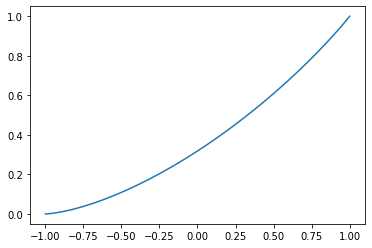

In [11]:
xs = jnp.linspace(-1+1e-6, 1, 100)
plt.plot(xs, reluf(xs)*2)
#plt.plot(xs, reluf_(xs))
#plt.plot([-1, 1], [-1, 1])

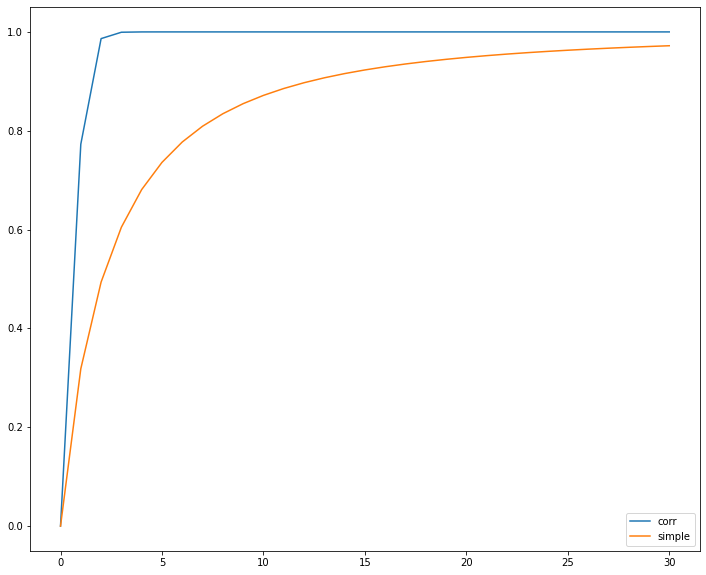

In [19]:
def evolve_relu(arr):
    x1, x2, cov = arr
    norm = (x1**.5 * x2**.5)
    rho = jnp.clip(cov/norm, -1., 1.)
    return jnp.array([x1/2, x2/2, norm * reluf(rho)])

def evolve_erf(arr):
    x1, x2, cov = arr
    ang = jnp.array([x1/(1+x1), x2/(1+x2),
                     jnp.clip(2*cov * ((1 + 2*x1) * (1 + 2*x2))**-.5, -1, 1)])
    return 2/jnp.pi * jnp.arcsin(ang)

def evolve(arr):
    x1, x2, cov = arr
    res = jnp.array([1-jnp.exp(-2*x1), 1-jnp.exp(-2*x2),
                    jnp.exp(cov-.5*x1-.5*x2) - jnp.exp(-cov-.5*x2-.5*x2)])
    return res/2



corr = jnp.array(0.)

sigw = 0.1
sigb = 0.1

s = jnp.array([1., 1., corr])
trace = [s]
t2 = [corr]
for _ in range(30):
    s = evolve_relu(s)*sigw + sigb
    corr = reluf(corr)*2
    trace.append(s)
    t2.append(corr)
x1, x2, cov = jnp.stack(trace).T

t2 = jnp.stack(t2).ravel()

_, ax = plt.subplots(1, 1, figsize=(12, 10))
norm = x1**.5 * x2**.5
#ax.plot(x1, label="x1")
#ax.plot(x2, label="x2")
#ax.plot(cov, label="cov")
ax.plot(cov/norm, label="corr")
ax.plot(t2, label='simple')
ax.legend()

In [ ]:
from neural_tangents import staxgg

In [ ]:
init_fn, apply_fn, kernel_fn = stax.serial(*([stax.Dense(512), stax.Relu()]*30), stax.Dense(1))

In [ ]:
jflat_x = jnp.array(flat_x.cpu().numpy().astype('float32'))

In [ ]:
arr = kernel_fn(jflat_x, jflat_x, 'nngp')

In [ ]:
M = (jflat_x @ jflat_x.T) / jflat_x.shape[1]
evolve([M[0, 0], M[1, 1], M[0, 1]])

In [ ]:
arr.dlpack()

In [ ]:
import jax.dlpack as jpack
import torch.utils.dlpack as tpack

In [ ]:
K = gpytorch.lazy.NonLazyTensor(tpack.from_dlpack(jpack.to_dlpack(arr)))

# Sine activations

In [ ]:
xs = np.linspace(0., 1., 100)

plt.plot(xs, .5*(1 - np.exp(-2*xs)))

In [ ]:
xs = np.linspace(-1, 1, 100)
plt.plot(xs, .5*(np.exp(xs - 2) - np.exp(-xs - 2)))